In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


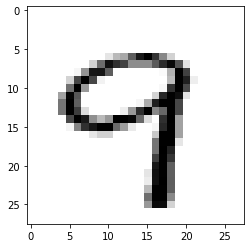

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

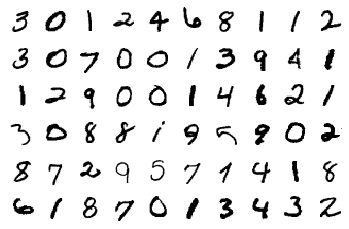

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),

        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),

        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            

        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            

        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            

        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            

        ) # output_size = 6
        

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(6, 6), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 




    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
       
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             160
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7            [-1, 8, 10, 10]             720
              ReLU-8            [-1, 8, 10, 10]               0
            Conv2d-9              [-1, 8, 8, 8]             576
             ReLU-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 12, 6, 6]             864
             ReLU-12             [-1, 12, 6, 6]               0
           Conv2d-13             [-1, 10, 6, 6]           1,080
             ReLU-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9)
from torch.optim.lr_scheduler import StepLR
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.057656869292259216 Batch_id=468 Accuracy=73.86: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1199, Accuracy: 9616/10000 (96.16%)

EPOCH: 1


Loss=0.13016100227832794 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:10<00:00, 44.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9782/10000 (97.82%)

EPOCH: 2


Loss=0.05661700293421745 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:10<00:00, 45.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9795/10000 (97.95%)

EPOCH: 3


Loss=0.014996777288615704 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:10<00:00, 44.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


Loss=0.014158795587718487 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:10<00:00, 53.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9824/10000 (98.24%)

EPOCH: 5


Loss=0.01463519036769867 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 42.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9829/10000 (98.29%)

EPOCH: 6


Loss=0.08165868371725082 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:10<00:00, 50.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9774/10000 (97.74%)

EPOCH: 7


Loss=0.015742754563689232 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 45.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9834/10000 (98.34%)

EPOCH: 8


Loss=0.07218628376722336 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9862/10000 (98.62%)

EPOCH: 9


Loss=0.034565869718790054 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9868/10000 (98.68%)

EPOCH: 10


Loss=0.04501953348517418 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9894/10000 (98.94%)

EPOCH: 11


Loss=0.014827718026936054 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9867/10000 (98.67%)

EPOCH: 12


Loss=0.007120852824300528 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9883/10000 (98.83%)

EPOCH: 13


Loss=0.001671860576607287 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9858/10000 (98.58%)

EPOCH: 14


Loss=0.033515915274620056 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 43.83it/s]



Test set: Average loss: 0.0403, Accuracy: 9863/10000 (98.63%)



Text(0.5, 1.0, 'Test Accuracy')

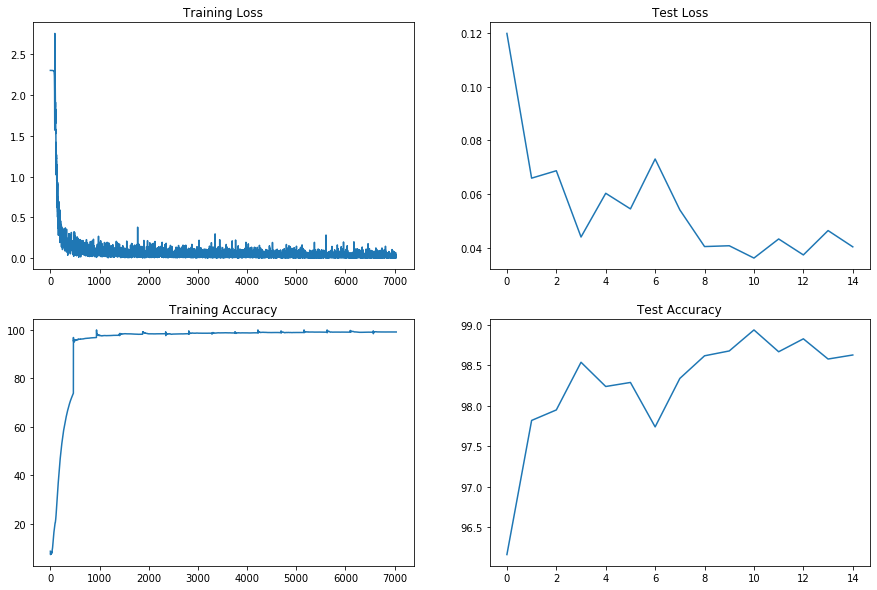

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")